This notebook explores the gradient descent dynamics on a simple,two-dimensional "GAN" example. While the *true* dataset consists of scalars drawn uniformly within $[0,1]$, the *noise* data is randomly sampled from $U[1,2]$. Discriminator and Generator are simple linear models in the form of $Wx+b$, where we fix $W_G=W_D=1$ to keep the dimensionality low. The following non-linear activation function is applied by the discriminator:

$$d(x)=exp(-(W_Dx+b_D)^2)$$

As a result, the Generator must learn to shift its input by $b_G=-1$ in order to successfuly re-generate the true data. The setting is inspired by: http://www.araya.org/archives/1183

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from stable_log_one_minus_exp import *
%matplotlib notebook

n=1000 #sample size
real=np.random.uniform(0.0,1.0,n) # "real" data
fake=np.random.uniform(1.0,2.0,n) # noisy input for G
w_D=1
w_G=1

In [23]:
def compute_gradients(b_D,b_G, real_batch, fake_batch):
# forward pass
    forward_D_real=0.001 + 0.998*np.exp(-(np.dot(real_batch,w_D)+b_D)**2) #margins for numerical stability
    forward_G=np.dot(fake_batch,w_G)+b_G
    z=np.dot(forward_G,w_D)+b_D
    forward_D_fake=0.001 + 0.998*np.exp(-(z)**2)

    #calculate gradients
    if loss_type=='min_max':
        gradient_D=(np.sum(-2*(np.dot(real_batch,w_D)+b_D))+np.sum(2*z*forward_D_fake/(1-forward_D_fake)))/(real_batch.size+fake_batch.size)
        gradient_G=np.sum(2*z*forward_D_fake/(1-forward_D_fake))/(real_batch.size+fake_batch.size)
    elif loss_type=='min_min':
        gradient_D=-b_D
        gradient_G=b_G**3-b_G
    else:
        raise ValueError("Unknown losstype!")
        
    return gradient_D, gradient_G


def compute_gradients_minmin(b_D,b_G):
    gradient_D=b_D
    gradient_G=b_G**3-b_G
    return gradient_D, gradient_G
def make_plot(d,g,fig_number):
    s=0.2
    x_ax = np.arange(-1.6,1.6+s, s)   #Discriminator
    y_ax = np.arange(-1.6,1.6+s, s)   #Generator
    x_ax,y_ax = np.meshgrid(x_ax,y_ax)
    gradient_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
    gradient_G=np.zeros((y_ax.shape[0],y_ax.shape[1]))

    for i in range(x_ax.shape[0]):
        for j in range(x_ax.shape[1]):
             (gradient_D[i,j],gradient_G[i,j])=compute_gradients(x_ax[i,j],y_ax[i,j], real, fake)

    fig = plt.figure(fig_number)
    plt.streamplot(x_ax,y_ax,gradient_D,-gradient_G, density=4, linewidth='0.4')
    plt.gcf().set_size_inches((8,8))
    plt.show()
    plt.xlabel('Discriminator')
    plt.ylabel('Generator')
    plt.plot(d, g, '-o',c='darkmagenta',linewidth='0.75',alpha=1, markersize=4)


### plot objectives

<IPython.core.display.Javascript object>


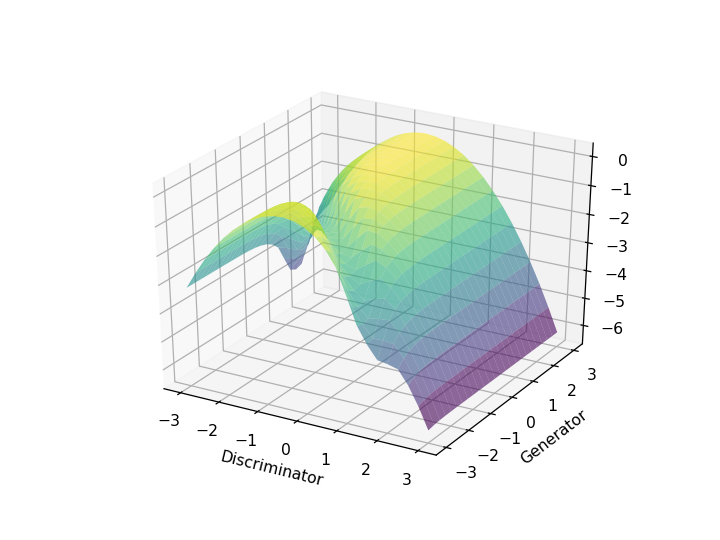

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [3]:
s=0.25
x_ax = np.arange(-3, 3+s, s)   #Discriminator
y_ax = np.arange(-3,3+s, s)   #Generator
x_ax,y_ax = np.meshgrid(x_ax,y_ax)
z_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
z_G=np.zeros((x_ax.shape[0],x_ax.shape[1]))


for i in range(x_ax.shape[0]):
    for j in range(x_ax.shape[1]):
        forward_D_real=np.dot(real,w_D)+x_ax[i,j]
        forward_G=np.dot(fake,w_G)+y_ax[i,j]
        forward_D_fake=np.dot(forward_G,w_D)+x_ax[i,j]
        z_D[i,j]=(np.sum(-forward_D_real**2)+np.sum(log_one_minus_exp_minus_a(forward_D_fake**2)))/(2*n)
        z_G[i,j]=-z_D[i,j]

fig = plt.figure(1)
ax = fig.gca(projection='3d')       
ax.plot_surface(x_ax, y_ax, z_D,cmap='viridis', 
                    alpha=0.6)            
plt.xlabel('Discriminator')
plt.ylabel('Generator')
plt.scatter(1,1,-5000)

### Optimize 

In [83]:
epochs=1

sample_size=n
global loss_type
loss_type='min_min'

#### Gradient Descent

<IPython.core.display.Javascript object>


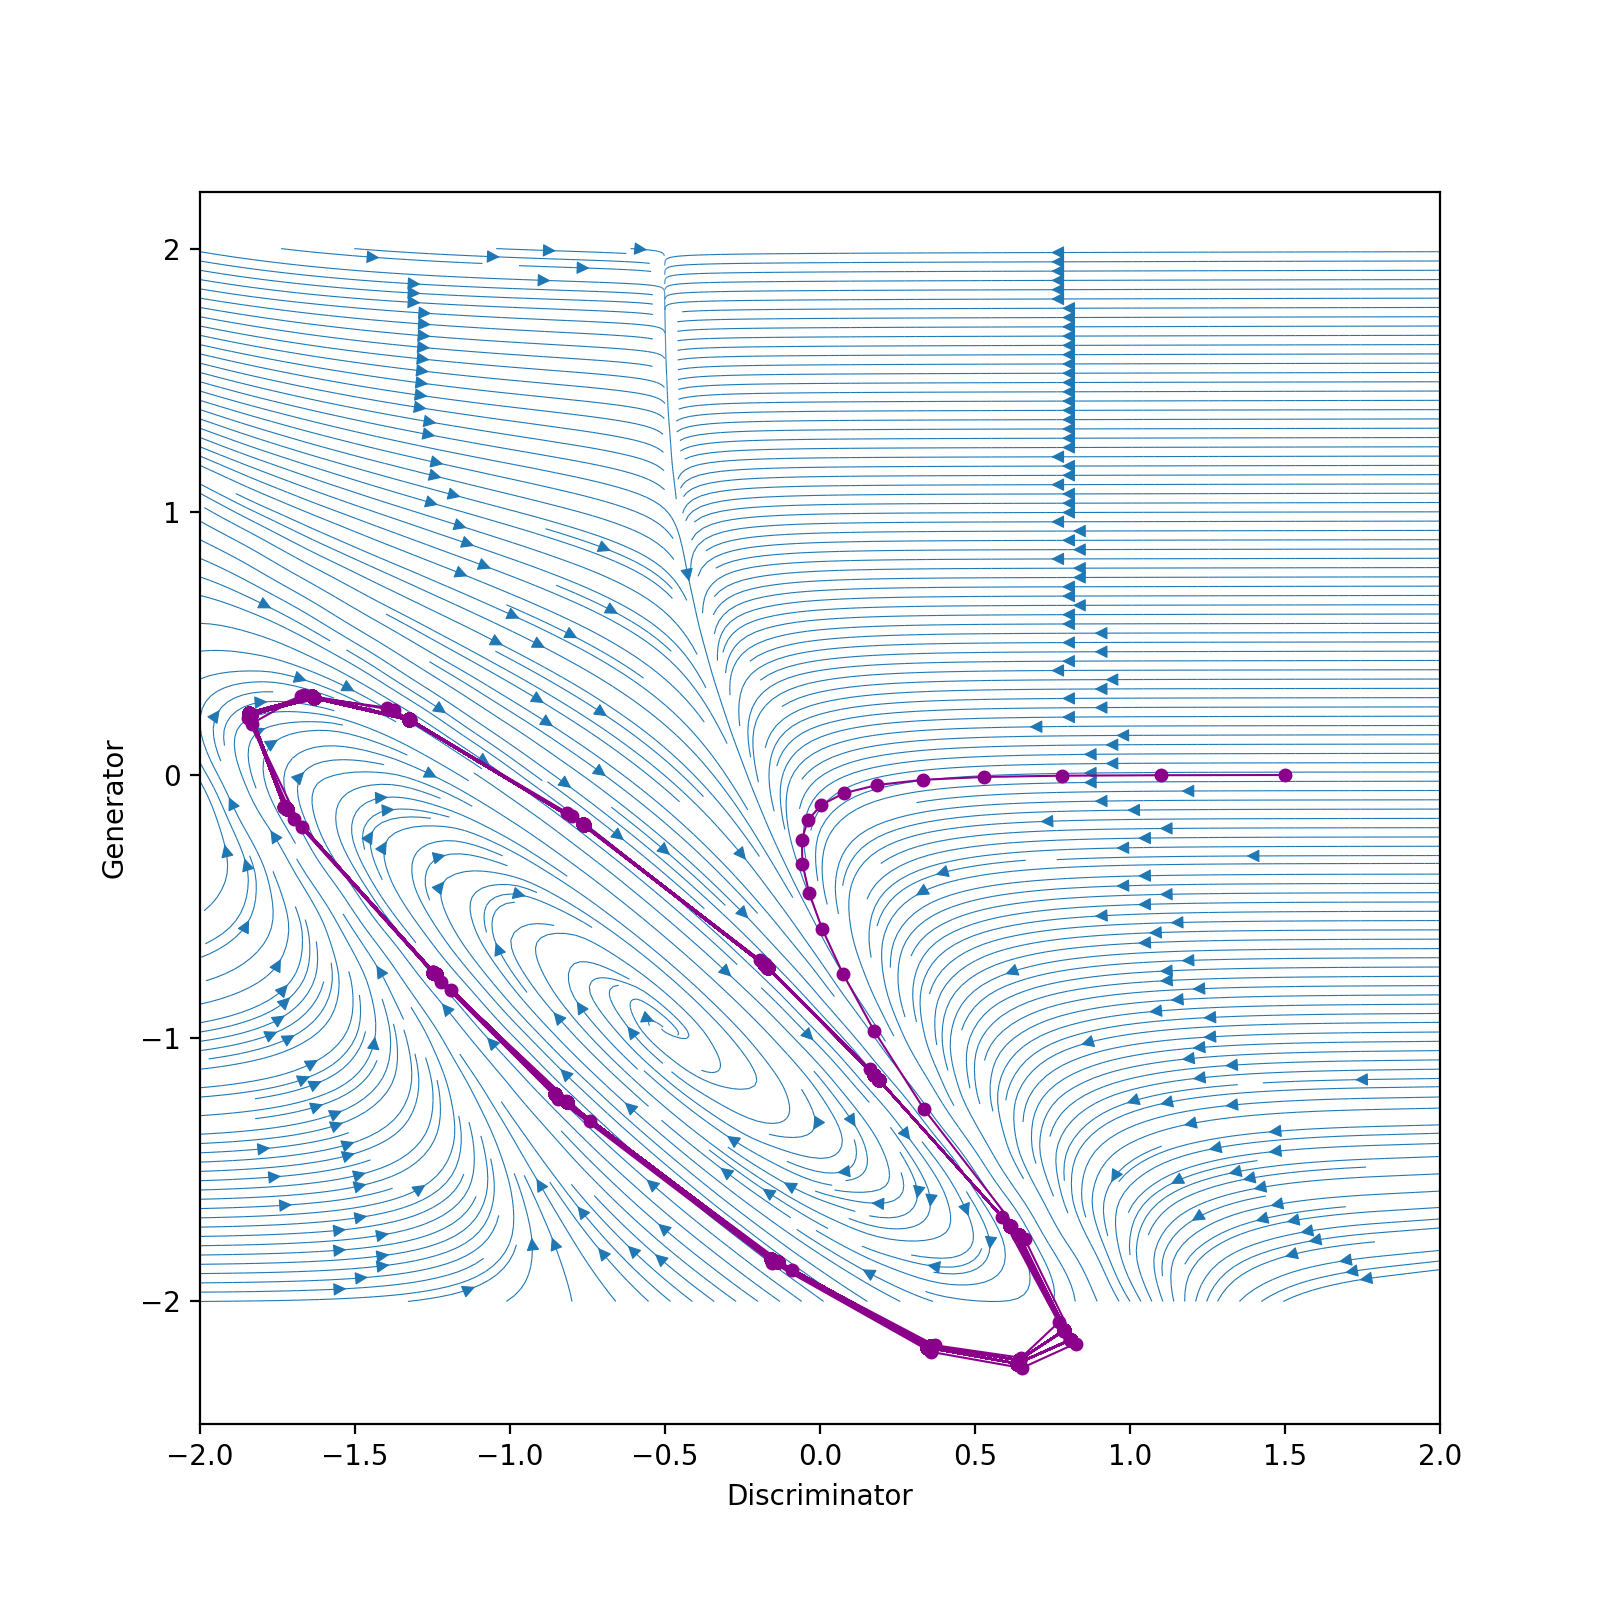

In [81]:
# Run GD (simultaneously)
iterates_D=[]
iterates_G=[]
iterations=850
step_size=0.2
b_D=1.5
b_G=0.0001

for k in range(iterations): 
    #Sample
    idx=np.random.permutation(1000)[0:sample_size]
    real_batch=real[idx]
    fake_batch=fake[idx]
        #safe iterates
    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
   
    #take step
    (gradient_D,gradient_G)=compute_gradients(b_D,b_G, real_batch, fake_batch)  
    b_D=b_D+step_size*gradient_D
    b_G=b_G-step_size*gradient_G


# Plot iterates
make_plot(iterates_D, iterates_G,2)


#### Accelerated Gradient Descent

<IPython.core.display.Javascript object>


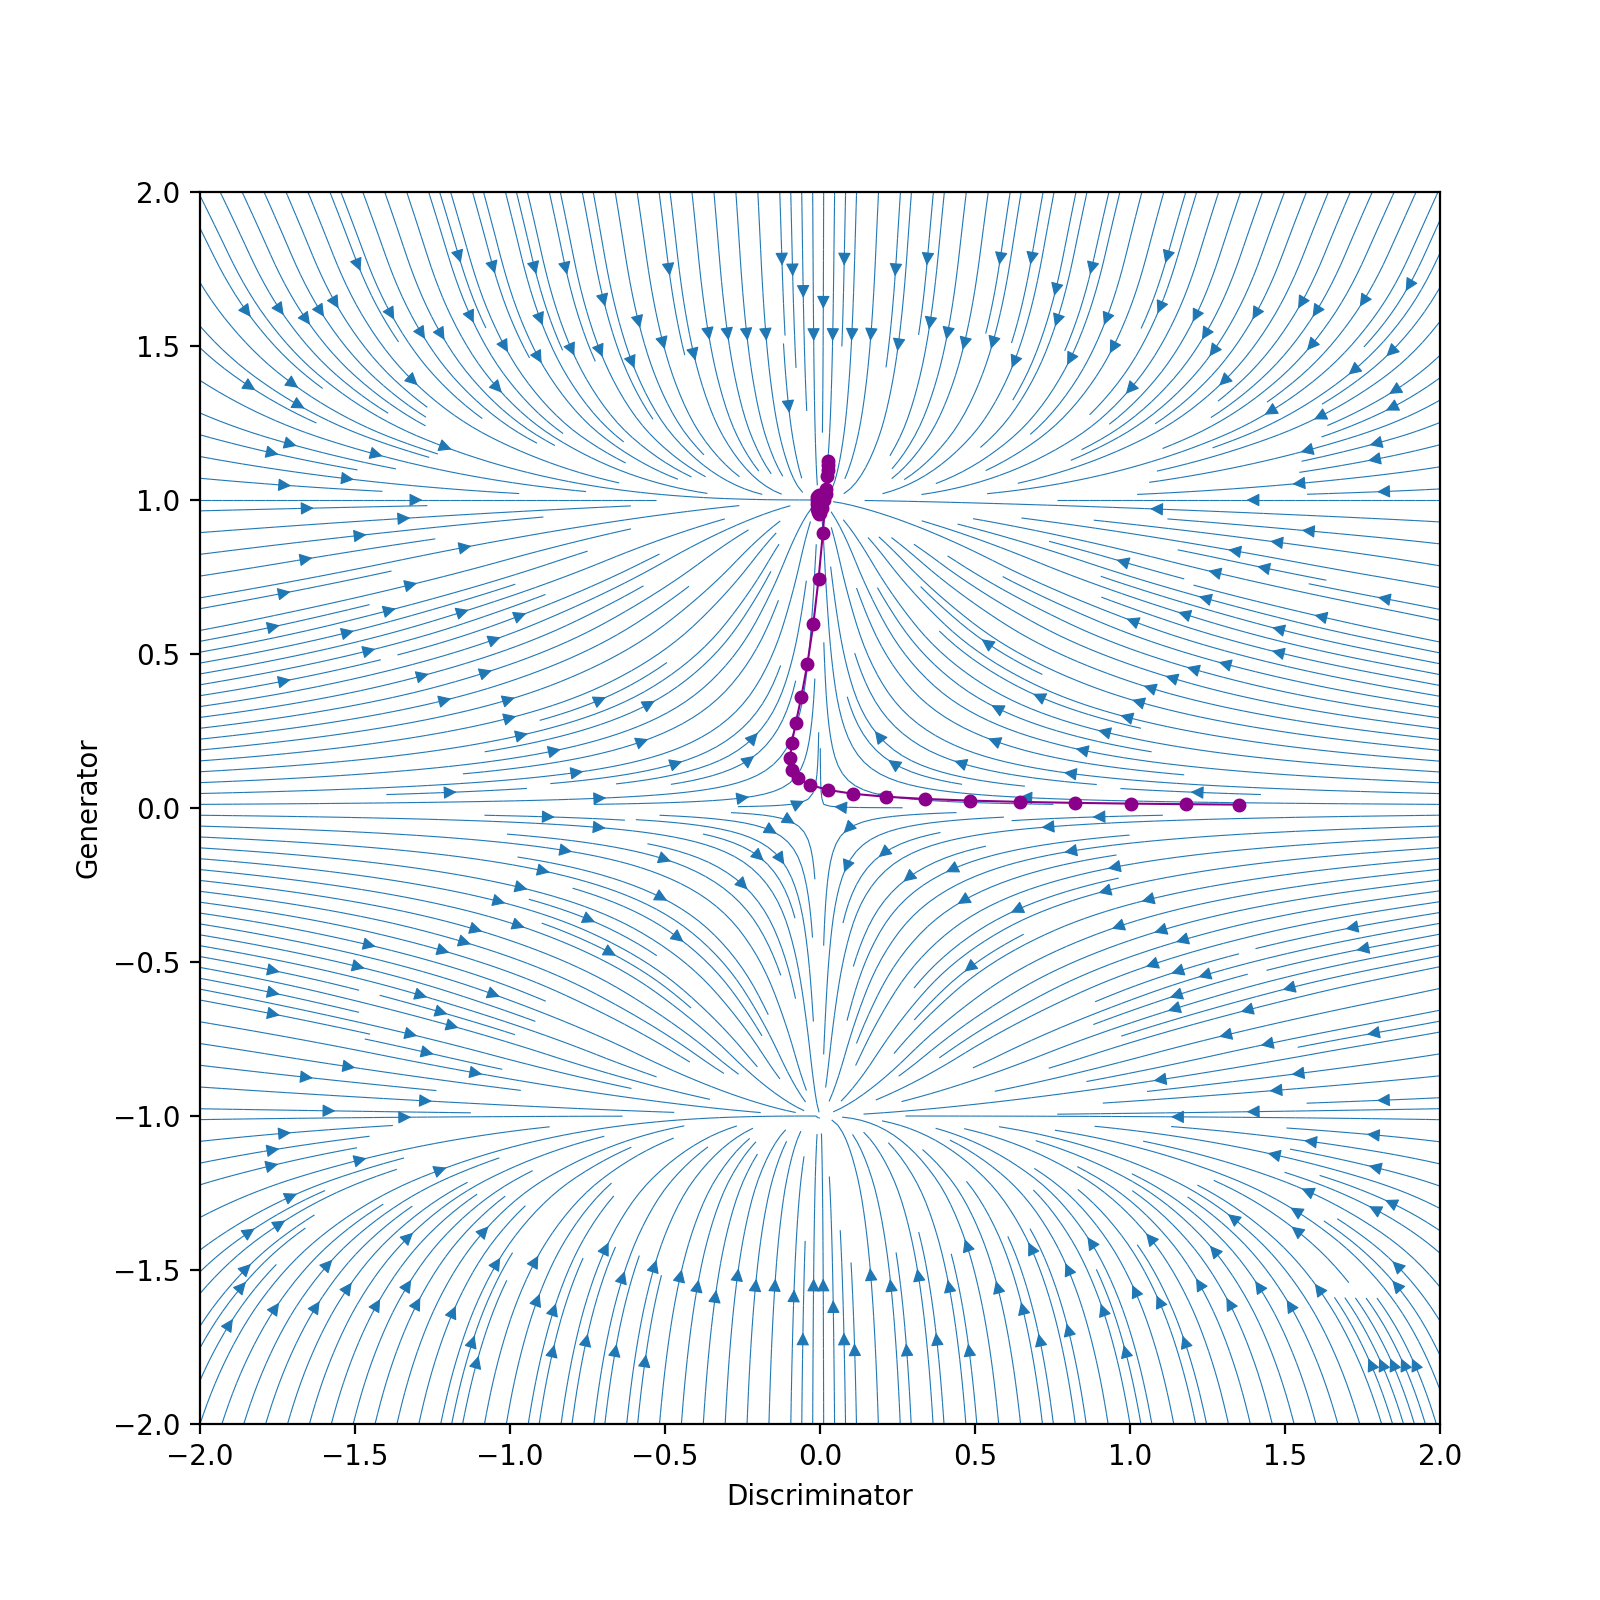

In [84]:
# Run AGD (simultaneously)
iterations=50
step_size=0.1
iterates_D=[]
iterates_G=[]
b_D=1.5
b_G=0.01
b_D_old=1.5
b_G_old=0.01

for k in range(1,iterations): 
    #Sample
    idx=np.random.permutation(1000)[0:sample_size]
    real_batch=real[idx]
    fake_batch=fake[idx]
    #compute y_(k)
    y_D=b_D+(k-1)/(k+2)*(b_D-b_D_old)
    y_G=b_G+(k-1)/(k+2)*(b_G-b_G_old)
    #store x_(k-1)
    b_D_old=b_D
    b_G_old=b_G
    #compute gradients
    (gradient_D,gradient_G)=compute_gradients(y_D,y_G, real_batch, fake_batch)
    b_D=y_D+step_size*gradient_D
    b_G=y_G-step_size*gradient_G

    #safe iterates
    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,3)

#### Extra Gradient

<IPython.core.display.Javascript object>


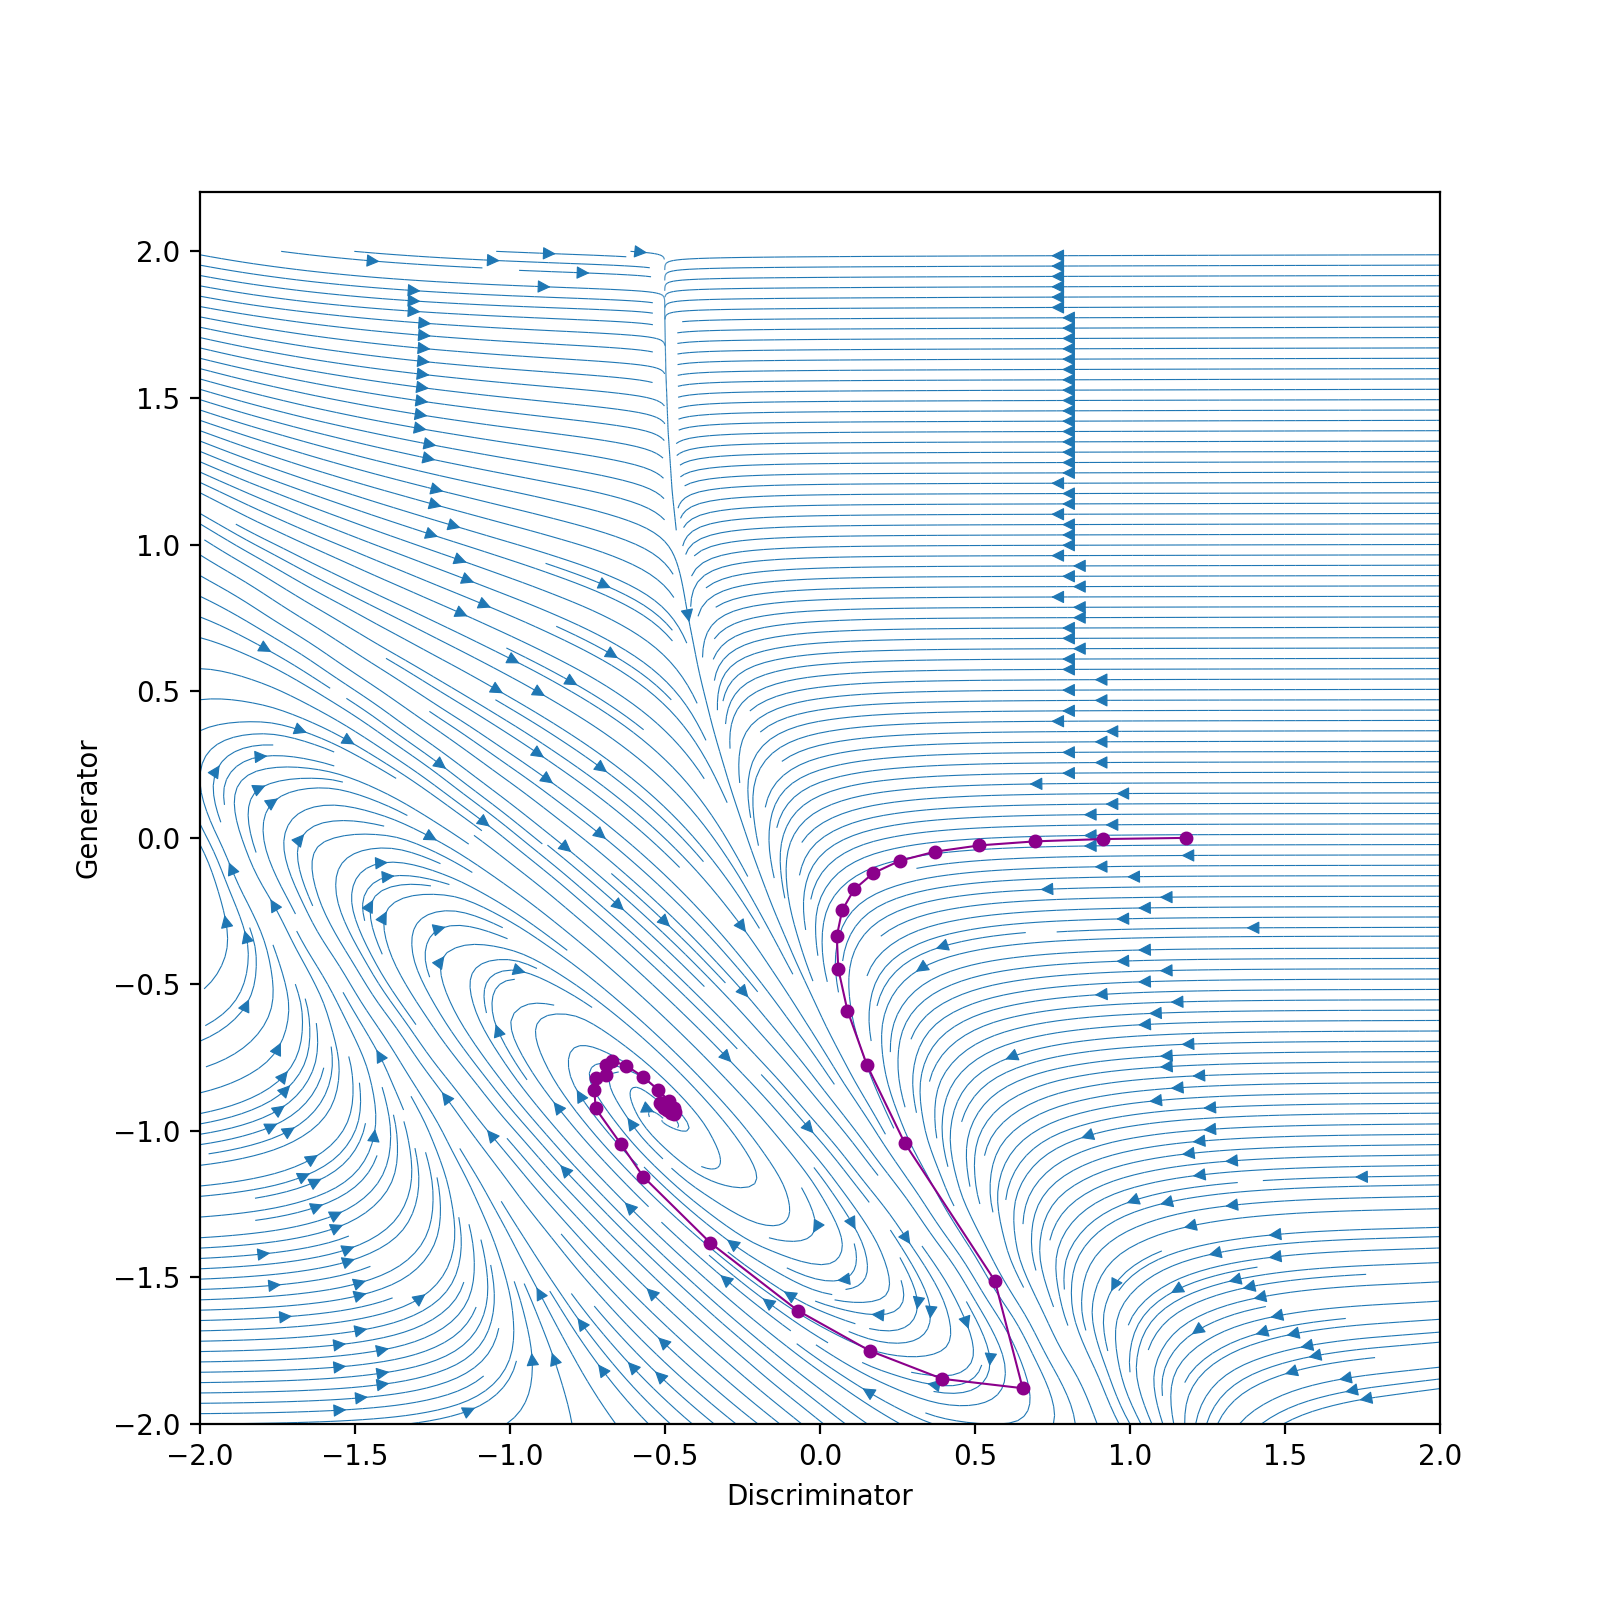

In [76]:
#Run EG
iterates_D=[]
iterates_G=[]
iterations=400
step_size=0.2
b_D=1.5
b_G=0.001
for k in range(iterations): # reshuffling and multiple D steps make no sense here??
    #Sample
    idx=np.random.permutation(1000)[0:sample_size]
    real_batch=real[idx]
    fake_batch=fake[idx]

    (gradient_D,gradient_G)=compute_gradients(b_D,b_G, real_batch, fake_batch)

    #intermediate GD step 
    b_D_extra=b_D+step_size*gradient_D
    b_G_extra=b_G-step_size*gradient_G

    (gradient_D_extra,gradient_G_extra)=compute_gradients(b_D_extra,b_G_extra, real_batch, fake_batch)

    #apply extra gradients to original iterate
    b_D=b_D+step_size*gradient_D_extra
    b_G=b_G-step_size*gradient_G_extra        
    
    #save iterates
    iterates_D.append(b_D)
    iterates_G.append(b_G)
    
# Plot iterates
make_plot(iterates_D, iterates_G,4)

#### Plot gradient norms

<IPython.core.display.Javascript object>


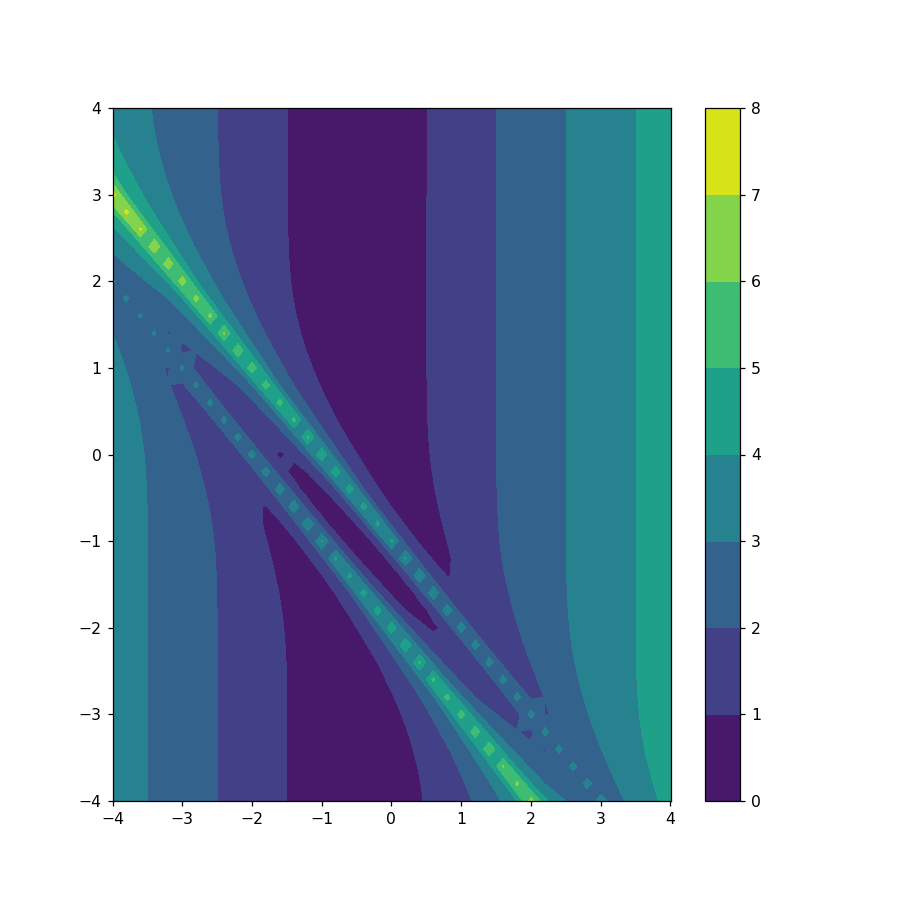

In [19]:
fig=plt.figure(5)
s=0.2
x_ax = np.arange(-4,4+s, s)   #Discriminator
y_ax = np.arange(-4,4+s, s)   #Generator
x_ax,y_ax = np.meshgrid(x_ax,y_ax)
gradient_D=np.zeros((x_ax.shape[0],x_ax.shape[1]))
gradient_G=np.zeros((y_ax.shape[0],y_ax.shape[1]))

for i in range(x_ax.shape[0]):
    for j in range(x_ax.shape[1]):
        (gradient_D[i,j],gradient_G[i,j])=compute_gradients(x_ax[i,j],y_ax[i,j], real, fake)
    

z = np.array(np.sqrt(np.array(gradient_D)**2+np.array(gradient_G)**2))
z = z.reshape((len(x_ax), len(y_ax)))
plt.contourf(x_ax,y_ax,z)
plt.colorbar()
plt.gcf().set_size_inches((8,8))
plt.show()

